* https://towardsdatascience.com/forecasting-stock-prices-using-prophet-652b31fb564e
  * https://github.com/NGYB/Stocks/blob/master/StockPricePrediction_fh21/StockPricePrediction_v2_prophet.ipynb
* https://towardsdatascience.com/aifortrading-2edd6fac689d#f88a
* https://www.kaggle.com/residentmario/gaussian-process-regression-and-classification
* https://github.com/gdroguski/GaussianProcesses
* https://towardsdatascience.com/an-intuitive-guide-to-gaussian-processes-ec2f0b45c71d
* https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

In [1]:
%matplotlib inline
import requests
import numpy as np
import sklearn.metrics as sklm
import pandas as pd
import io
import matplotlib.pyplot as plt

from fbprophet import Prophet

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt

In [2]:
default_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Get BMO Mutual Fund Data

In [3]:
def get_bmo_stock_data(symbol):
    """Returns a pandas dataframe of daily fund price history from the last year.
    
    The fund symbol can be manually retrieved by accessing fund price history
    csvs from https://www.bmo.com/main/personal/investments/mutual-funds/
    
    Code based on
    https://stackoverflow.com/questions/35371043/use-python-requests-to-download-csv
    and
    https://stackoverflow.com/questions/39213597/convert-text-data-from-requests-object-to-dataframe-with-pandas
    """

    csv_url = ("https://bmomf.lipperweb.com/Profile/DownloadHistory?symbol"
               "={symbol}&tab=History&timeFrame=All&interval=0&period=1&"
               "startDate=&endDate=&format=csv&lang=en")
    
    with requests.Session() as s:
        url_data = s.get(csv_url.format(symbol=symbol)).content
        fund_price = (pd.read_csv(io.StringIO(url_data.decode('utf-8')),
                                  parse_dates=[0,])
                      .sort_values('Effective Date')
                      .reset_index(inplace=False, drop=True))
    return fund_price

def get_reduced_bmo_stock_data(symbol):
    """Wrapper around get_bmo_stock_data to only retrieve a timeseries of NAV data."""
    data = get_bmo_stock_data(symbol)
    data = data[['Effective Date', 'NAV']]
    data.columns = ['Date', 'Net Asset Value']
    data.set_index('Date', drop=True, inplace=True)
    return data

In [4]:
# Eg. Dividend: 45121:95903; SelectTrust growth T6: 45121:17696; SelectTrust growth: 45121:94813
stg = get_reduced_bmo_stock_data('45121:94813')
stg

,Net Asset Value
Date,
2013-08-13,10.0414
2013-08-14,10.0206
2013-08-15,9.9629
2013-08-16,9.9789
2013-08-19,9.9252
...,...
2019-11-11,13.1894
2019-11-12,13.2036
2019-11-13,13.2160


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


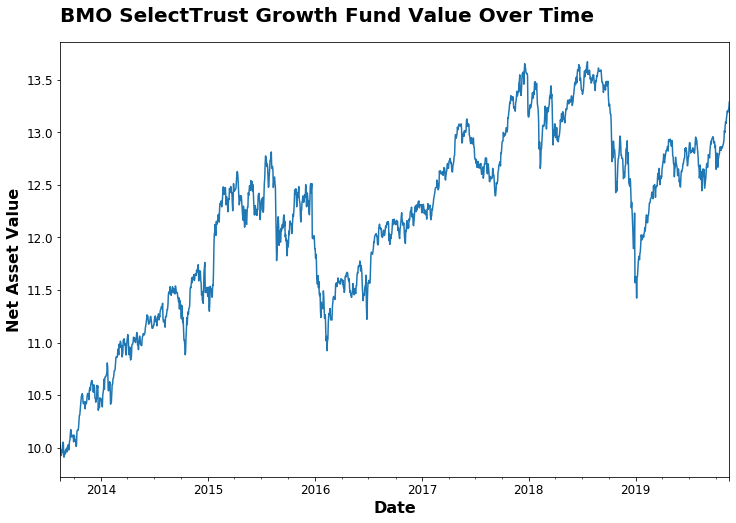

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
stg['Net Asset Value'].plot(ax=ax, legend=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title("BMO SelectTrust Growth Fund Value Over Time", fontsize=20,
             fontweight='bold', loc='left', pad=20)
ax.set_xlabel('Date', fontsize=16, fontweight='bold')
ax.set_ylabel('Net Asset Value', fontsize=16, fontweight='bold');

## FB Prophet

Following [this blog post](https://towardsdatascience.com/forecasting-stock-prices-using-prophet-652b31fb564e) and its associated [Jupyter Notebook](https://github.com/NGYB/Stocks/blob/master/StockPricePrediction_fh21/StockPricePrediction_v2_prophet.ipynb):
* We have 5+ years of stock prices.
* We following the author's staggered train/dev/test split:
  * `252 * 3 = 756` days for training, `252` for hyperparameter tuning validation.
  * Use a moving-window validation strategy (timeseries equivalent to k-fold) - try forecast horizon 21 trading days (1 month) for the first 756, then shift window for both train and dev set forward 11 days, then train again.  `252 / 11` gives around 20 windows.
  * RMSE, MAE and mean absolute percentage error (MAPE)

In [6]:
train_size = 252 * 3                     # Use 3 years of data as train set
val_size = 252                         # Use 1 year of data as validation set
train_val_size = train_size + val_size # Size of train+validation set
i = train_val_size                     # Day to forecast
H = 21                                 # Forecast horizon

In [7]:
def prepare_inputs(stg, start_i, end_i):
    # Reset index so date is its own column.
    stg_sub = stg.iloc[start_i:end_i, :].copy().reset_index()
    # Prophet expects a Pandas DataFrame with 'ds' for time and 'y' for dependent variable.
    # see eg. https://facebook.github.io/prophet/docs/quick_start.html
    stg_sub.columns = ['ds', 'y']
    return stg_sub

In [8]:
# Fit Prophet model.
prophet_model = Prophet(daily_seasonality=False)
stg_sub = prepare_inputs(stg, i - train_val_size, i)
# prophet_model.fit returns itself, so use ;
prophet_model.fit(stg_sub);

In [9]:
def get_pred_dates(pm, periods, include_history=True):
    # Returns a set of dates for Prophet to predict on, historical
    # dates used in training and some number of future days specified
    # by `periods`.
    future = pm.make_future_dataframe(periods=periods, freq='D',
                                      include_history=include_history)
    # Only include weekdays.
    future['day'] = future['ds'].dt.weekday
    future = future[future['day'] <= 4]
    return future

In [10]:
# Use 2 * H to ensure that after we remove weekends we still have more than H days.
pred_dates = get_pred_dates(prophet_model, 2 * H)

In [11]:
# Try forecasting.
forecast = prophet_model.predict(pred_dates)

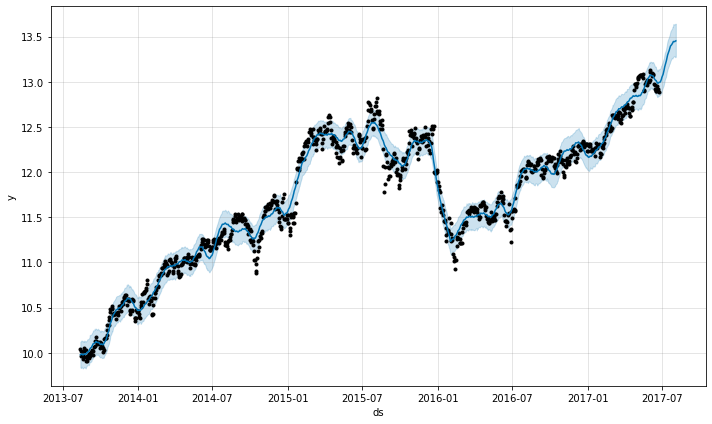

In [12]:
prophet_model.plot(forecast);

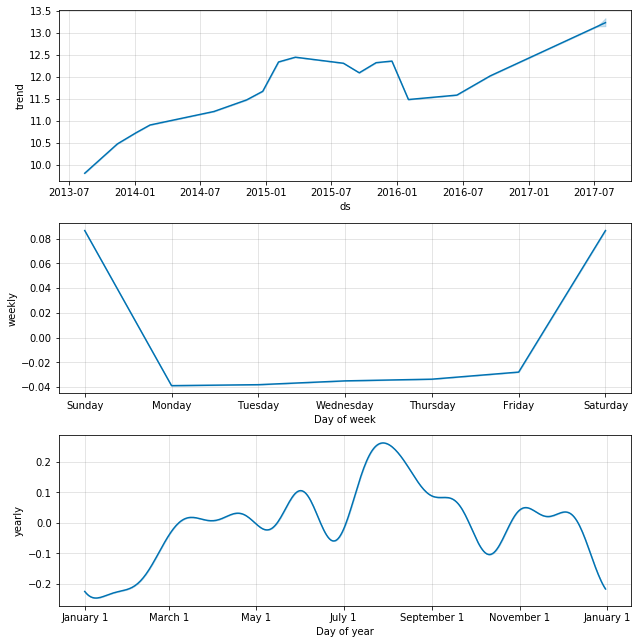

In [13]:
prophet_model.plot_components(forecast);

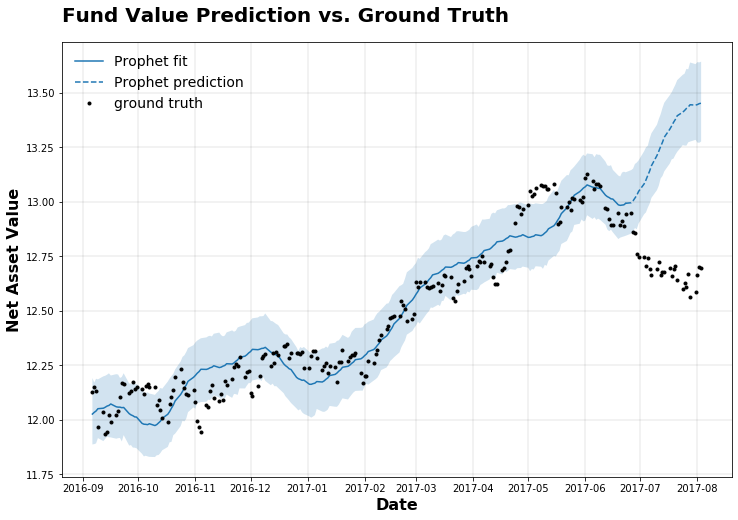

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.plot(forecast.loc[800:1008, 'ds'], forecast.loc[800:1008, 'yhat'],
        c=default_colours[0], label='Prophet fit')
ax.plot(forecast.loc[1008:, 'ds'], forecast.loc[1008:, 'yhat'],
        c=default_colours[0], ls='dashed', label='Prophet prediction')
ax.fill_between(forecast.loc[800:, 'ds'],
                forecast.loc[800:, 'yhat_lower'],
                y2=forecast.loc[800:, 'yhat_upper'], alpha=0.2)
ax.plot(forecast.loc[800:, 'ds'], stg.loc[forecast.loc[800:, 'ds'], 'Net Asset Value'],
        'ko', ms=3, label='ground truth')
ax.set_xlabel('Date', fontsize=16, fontweight='bold')
ax.set_ylabel('Net Asset Value', fontsize=16, fontweight='bold')
ax.set_title("Fund Value Prediction vs. Ground Truth", fontsize=20,
             fontweight='bold', loc='left', pad=20)
ax.legend(loc=2, facecolor='white', frameon=False, fontsize=14);

In [55]:
def get_rmse(start_i, end_i, y, gt):
    return np.sqrt(sklm.mean_squared_error(
        gt['Net Asset Value'].iloc[start_i:end_i],
        y['trend'].iloc[start_i:end_i]))

def get_mae(start_i, end_i, y, gt):
    return sklm.mean_absolute_error(
        gt['Net Asset Value'].iloc[start_i:end_i],
        y['trend'].iloc[start_i:end_i])

def get_mape(start_i, end_i, y, gt):
    yv = y['trend'].iloc[start_i:end_i].values
    gtv = gt['Net Asset Value'].iloc[start_i:end_i].values
    return (np.abs(yv - gtv) / gtv).mean() * 100.

In [56]:
print("RMSE: ", get_rmse(train_val_size, train_val_size + H, forecast, stg),
      "MAE: ", get_mae(train_val_size, train_val_size + H, forecast, stg),
      "MAPE: ", get_mape(train_val_size, train_val_size + H, forecast, stg))

RMSE:  0.4132914184555808 MAE:  0.3971103384776483 MAPE:  3.123679075731391


To compare, we can use the Last Value method as a benchmark, where we simply set all future prices to the last observed price in the training data.

In [75]:
class LastValueMethod:
    
    def __init__(self):
        self._data = None
        
    def fit(self, input_data):
        self._data = input_data
    
    def predict(self, pred_data):
        prediction = pd.DataFrame(
            {'ds': pred_data['ds'].copy()})
        prediction.loc[:self._data.shape[0], 'trend'] = self._data['y']
        prediction.loc[self._data.shape[0]:, 'trend'] = self._data.iat[-1, 1]
        return prediction

In [76]:
lvm = LastValueMethod()
lvm.fit(stg_sub)
lvm_forecast = lvm.predict(pred_dates)

In [78]:
print("RMSE: ", get_rmse(train_val_size, train_val_size + H, lvm_forecast, stg),
      "MAE: ", get_mae(train_val_size, train_val_size + H, lvm_forecast, stg),
      "MAPE: ", get_mape(train_val_size, train_val_size + H, lvm_forecast, stg))

RMSE:  0.17516062152588258 MAE:  0.16243333333333373 MAPE:  1.2785599776794099


So our prediction sucks.  Can we do better with a hyperparameter search?